# Street Network Analysis: Nodes and Paths (Local Files)

In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
pd.options.display.float_format = '{:20.2f}'.format
pd.options.mode.chained_assignment = None

import cityImage as ci

**Ininitialising path, names, etc.**

In [2]:
city_name = 'Boston'
output_path ='output/'+city_name+'/'
epsg = 26986
crs = 'EPSG:'+str(epsg)

## Loading the Files

Provide files' directories and loading the data
The polygon is not strictly necessary. It is needed when clipping the Street Network

In [3]:
#specify your loading paths here 
input_path_polygon = ''
input_path =  '../data/boston_4000.shp'

**A note**:

To avoid the edge effect when computing betweennes centrality values, consider using an area larger than your actual case-study area. 

In [4]:
# Leave "None" for attributes not contained in the dataframe or for attributes of no interest.
dict_columns = {"roadType_field": None,  "direction_field": None, "speed_field": None, "name_field": None}
# if all items are None, don't pass the dictionary in the function

nodes_graph, edges_graph = ci.get_network_fromFile(input_path, epsg)

## Cleaning and simplyfing the Street Network

At the end of the previous section two files are obtained: nodes and edges (vertexes and links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle (through boolean parameters):
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* `remove_islands`: Disconnected islands.
* `dead_ends` Dead-end street segments.
* `self_loops` Self-Loops.
* `same_vertexes_edges` Edges with same from-to nodes, but different geometries.
* `fix_topology` This creates nodes and breaks street segments at intersections. It is primarily useful for poorly formed datasets (usually OSM deerived networks are topologically correct). It accounts for segments classified as bridges or tunnels in OSM.

`same_vertexes_edges` handles edges with same pair of u-v nodes but different geometries. When `True`, it derives a center line between the two segments, unless one of the two segments is longer than the other (>10%). In this case, the shorter segment is deleted.

In [5]:
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_islands = True,
                            same_vertexes_edges = True, self_loops = True, fix_topology = False)

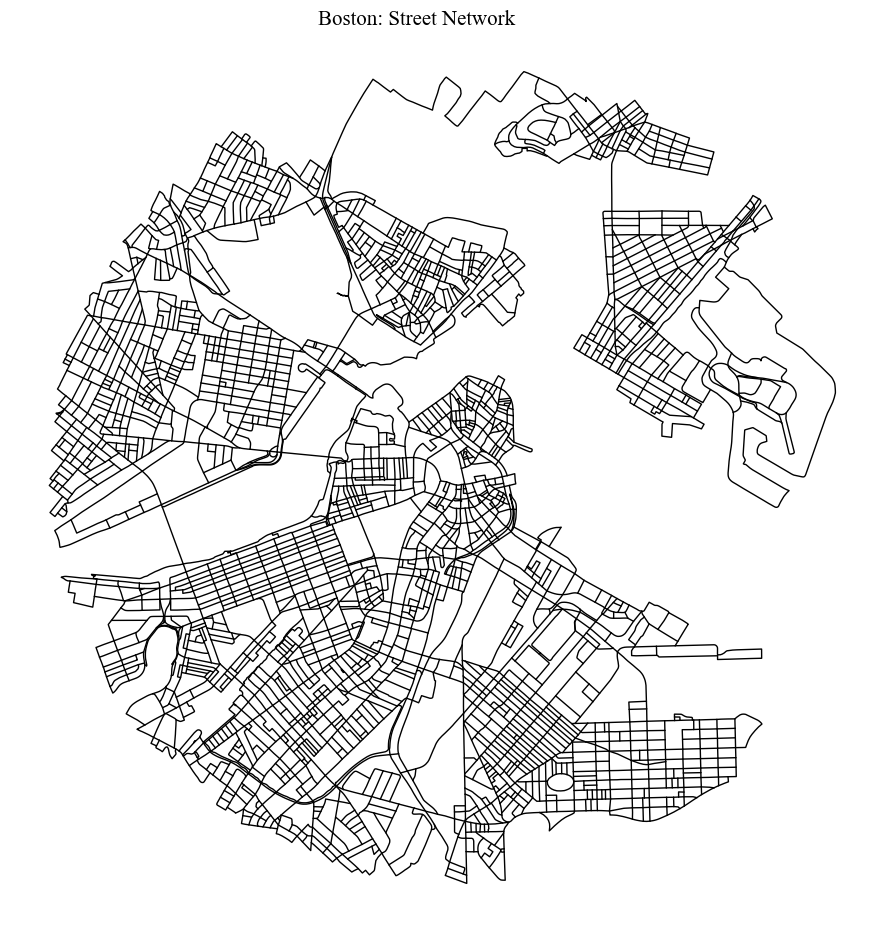

In [6]:
plot = ci.plot_gdf(edges_graph, black_background = False, figsize = (10,10), title = city_name+': Street Network',
                   color = 'black')

In [7]:
# Obtaining the graph from the case-study area and computing the centrality measures
graph = ci.graph_fromGDF(nodes_graph, edges_graph)

## Node centrality

On the primal graph representation of the street network, the following centrality measures are computed on nodes, on the basis of road distance:

* Road Distance Shortest Path Betweenness centrality (`Bc_Rd`).
* Straightness centrality (`Sc`) (see [Crucitti et al. 2006](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.73.036125)).
* Reach centrality (e.g. `Rc_400`, `Rc_600`) (readataped from [Sevtsuk & Mekonnen 2012](https://www.sutd.edu.sg/cmsresource/idc/papers/2012_Urban_Network_Analysis_A%20New%20Toolbox_for_ArcGIS.pdf)) - it measures the importance of a node based on the number of services (e.g. commercial activities) reachable by that node (for instance within a buffer).

`measure` accepts `betweenness`, `reach`, `straightness`, `closeness`. The function returns dictionaries, which are going to be merged in the GDF below.

The first measure (`Bc_Rd`) is here used to identify "Lynchian" nodes. 

In [8]:
# betweenness centrality
Bc_Rd = ci.calculate_centrality(nx_graph = graph, measure='betweenness', weight='length')
# straightness centrality
Sc = ci.calculate_centrality(nx_graph = graph, measure='straightness', weight='length', normalized = True)

If using POI from OSM: Choose which of the following amenities you consider relevant as "services" for computing reach centrlality. Check [OSM amenities](https://wiki.openstreetmap.org/wiki/Key:amenity) for details.

In [9]:
amenities = ['arts_centre', 'atm', 'bank', 'bar', 'bbq', 'bicycle_rental', 'bicycle_repair_station', 'biergarten', 
             'boat_rental', 'boat_sharing', 'brothel', 'bureau_de_change', 'cafe', 'car_rental', 'car_sharing', 'car_wash', 'casino', 'childcare',
           'cinema', 'clinic', 'college', 'community_centre', 'courthouse', 'crematorium', 'dentist', 'dive_centre', 'doctors', 
           'driving_school', 'embassy', 'fast_food', 'ferry_terminal', 'fire_station', 'food_court', 'fuel', 'gambling', 'gym', 
           'hospital', 'ice_cream', 'internet_cafe', 'kindergarten', 'kitchen', 'language_school', 'library', 'marketplace', 
           'monastery', 'motorcycle_parking', 'music_school', 'nightclub', 'nursing_home', 'pharmacy', 'place_of_worship', 
           'planetarium', 'police', 'post_office', 'prison', 'pub', 'public_building', 'ranger_station', 'restaurant', 'sauna',
           'school', 'shelter', 'shower', 'social_centre', 'social_facility', 'stripclub', 'studio', 'swingerclub', 'theatre', 
           'toilets', 'townhall', 'university', 'veterinary']

In [10]:
# reach centrality pre-computation, in relation to Point of Interests or any other point-geodataframes 
convex_hull_wgs = ci.convex_hull_wgs(edges_graph)
services = ox.geometries.geometries_from_polygon(convex_hull_wgs, tags = {'amenity':True}).to_crs(epsg=epsg)
services = services[services.amenity.isin(amenities)]
services = services[services['geometry'].geom_type == 'Point']
# using a 50 mt buffer
graph = ci.weight_nodes(nodes_graph, services, graph, field_name = 'services',  radius = 50)

# Reach Centrality
Rc400 = ci.calculate_centrality(nx_graph = graph, measure='reach', weight='length', radius = 400, attribute = 'services')
Rc600 = ci.calculate_centrality(nx_graph = graph, measure='reach', weight='length', radius = 600, attribute = 'services')

In [11]:
## Appending the attributes to the geodataframe
dicts = [Bc_Rd, Sc, Rc400, Rc600]
columns = ['Bc_Rd', 'Sc', 'Rc400', 'Rc600']
for n,c in enumerate(dicts): 
    nodes_graph[columns[n]] = nodes_graph.nodeID.map(c)

### Visualisation

In [12]:
col = ['Bc_Rd', 'Bc_Rw', 'Sc', 'Rc400', 'Rc600']
titles = ['Betweennes Centrality - Shortest Path', 'Straightness Centrality', 'Reach Centrality 400 mt radius', 
          'Reach Centrality 600 mt radius']

#### Parameters 

**Plot properties (optional)**:

* `black_background` black background or white
* `figsize`: size of the figure's side extent (15,10)
* `legend`: if True, show the legend
* `axes_frame`: if True, it shows an axis frame
* `fontsize`: the fontsize for texts

**What to plot (some may be required, depending on the function)**:

* `gdf`: the gdf to plot (only for the functions `plot_gdf` and `plot_grid_gdf_columns`)
    * `gdfs`: list of GeoDataFrames to plot (only for the function `plot_grid_gdfs_column`)
* `column`: the column of the gdf on which building the visualisation (only for the functions `plot_gdf` and `plot_grid_gdf_columns`)
    * `columns`: list of the columns on which building the visualisation (only for the function `plot_grid_gdf_columns`)

**How to plot (optional)**:

* `scheme`: the classification method, choose amongst: https://pysal.org/mapclassify/api.html
* `bins`: bins defined by the user
* `classes`: nr classes for visualising when scheme is not None
* `norm`: a desired data normalisation into a [min, max] interval
* `cmap`: see matplotlib colormaps for a list of possible values or pass a colormap
* `color`: categorical color applied to all geometries when not using a column to color them
* `alpha`: alpha value of the plotted layer
* `geometry_size` point size or line with value values, based on the geometry
* `geometry_size_factor`: when provided, it rescales the column provided, if any, from 0 to 1 and it uses the geoemtry_size_factor to rescale the markersize or the linewidth accordingly (e.g. rescaled variable's value [0-1] * factor), when plotting a Point GeoDataFrame
* `cbar`: if True, show colorbar, otherwise don't; when True it doesn't show legend. Related paramters are:
    * `cbar_shrink`: fraction by which to multiply the size of the colorbar.
    * `cbar_ticks`:  number of ticks along the colorbar
    * `cbar_max_symbol`:  if True, it shows the ">" next to the highest tick's label in the colorbar (useful when normalising)
    * `cbar_min_max`: if True, it only shows the ">" and "<" as labels of the lowest and highest ticks' the colorbar
* `gdf_base_map`, provide a GeoDataFrame that should be used as base-map. Related paramters are:        
    * `base_map_gdf`: a desired additional layer to use as a base map        
    * `base_map_color`color applied to all geometries of the base map
    * `base_map_alpha`: base map's alpha value
    * `base_map_geometry_size`: base map's markersize or linewidth when the base map is a Point GeoDataFrame or a LineString GeoDataFrame
    * `base_map_zorder`: zorder of the layer; e.g. if 0, plots first, thus main GeoDataFrame on top; if 1, plots last, thus on 
    
**Only for grid-like plot (multi gdfs or multi columns)**:

* `nrows`: number of rows of the subplot
* `ncols`: number of columns of the subplot

`nrows` x `ncols` must be equal (or +1) to the lenght of the gdfs or columns passed.

#### Grid visualisation

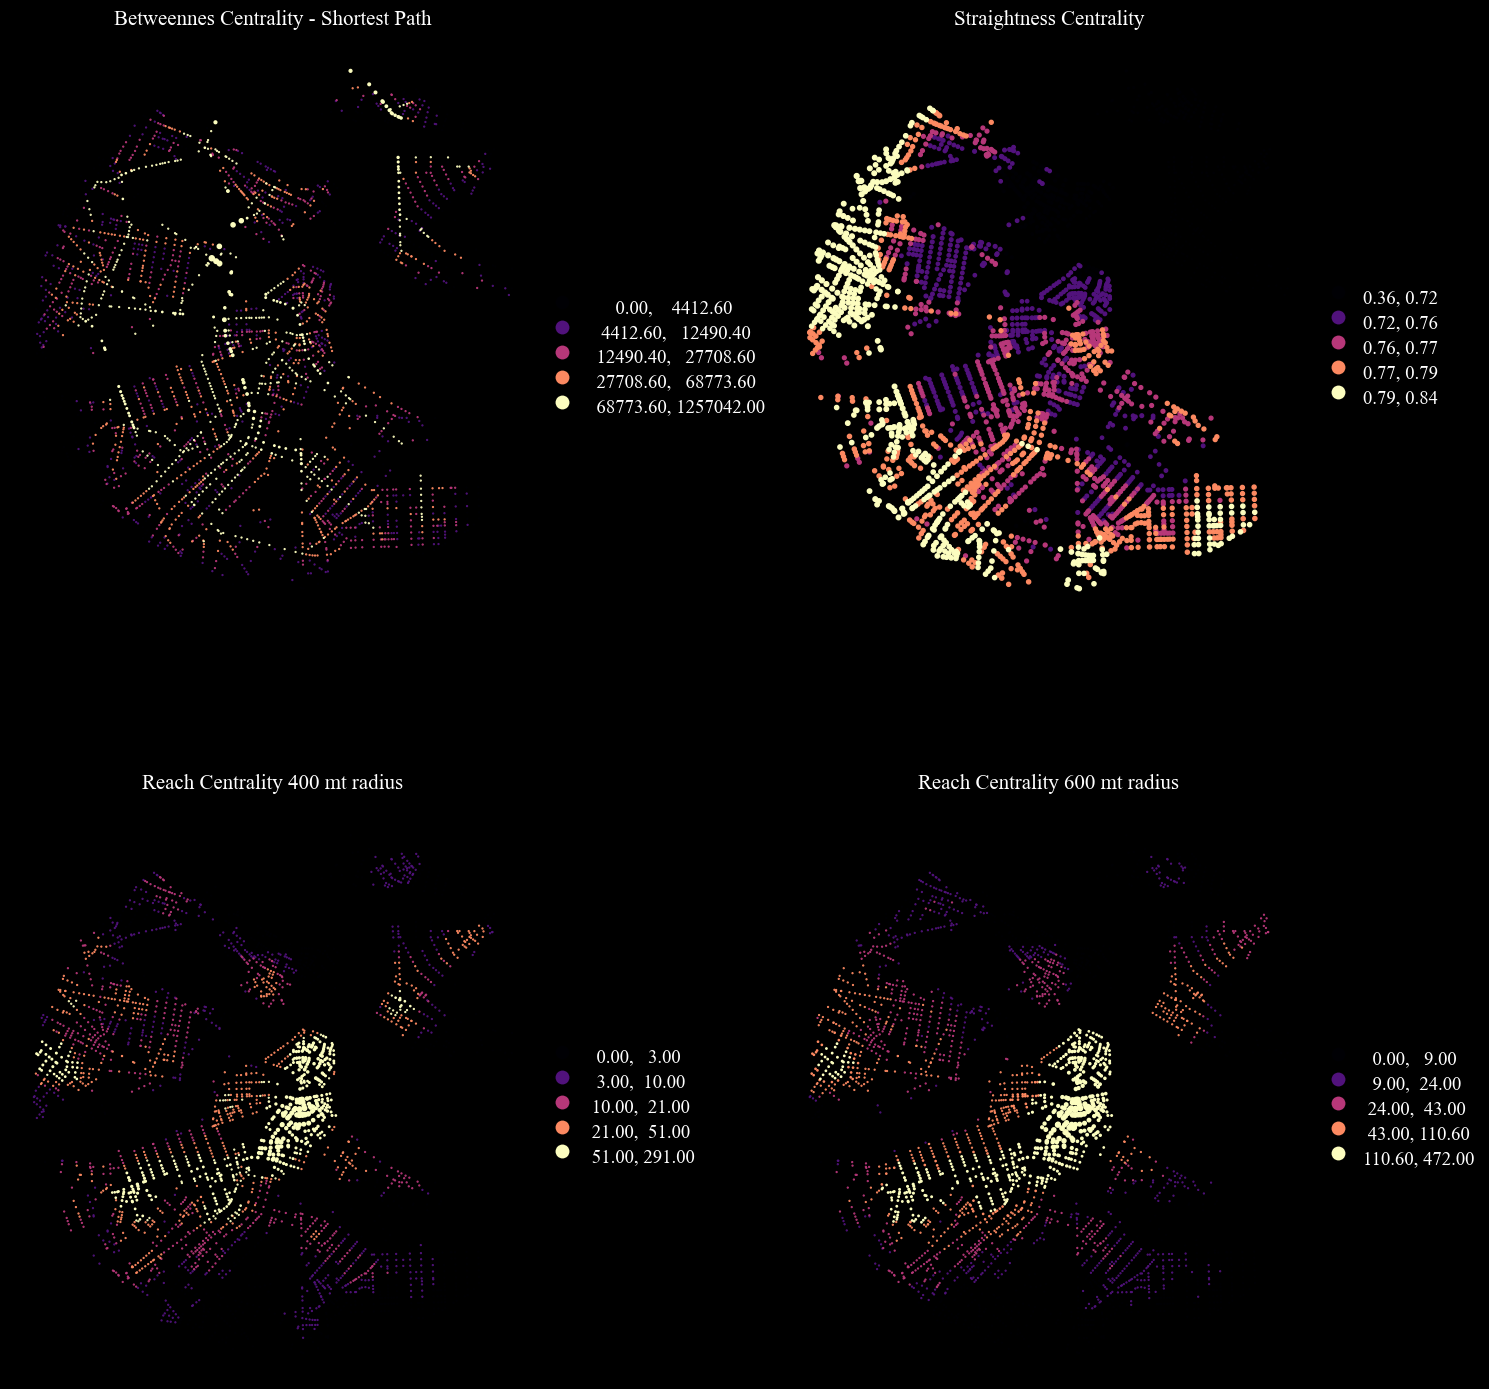

In [16]:
cbar_dict = {'cbar' : True, 'cbar_min_max' : True, 'cbar_shrink' : 0.30}
fig = ci.plot_grid_gdf_columns(nodes_graph, titles = titles, columns = columns, cmap = 'magma', scheme = 'quantiles', classes = 5,
                               figsize = (15,20), nrows = 2, ncols = 2,  geometry_size_factor = 3.5, legend = True)

#### Single figure visualisation with Lynch derived breaks

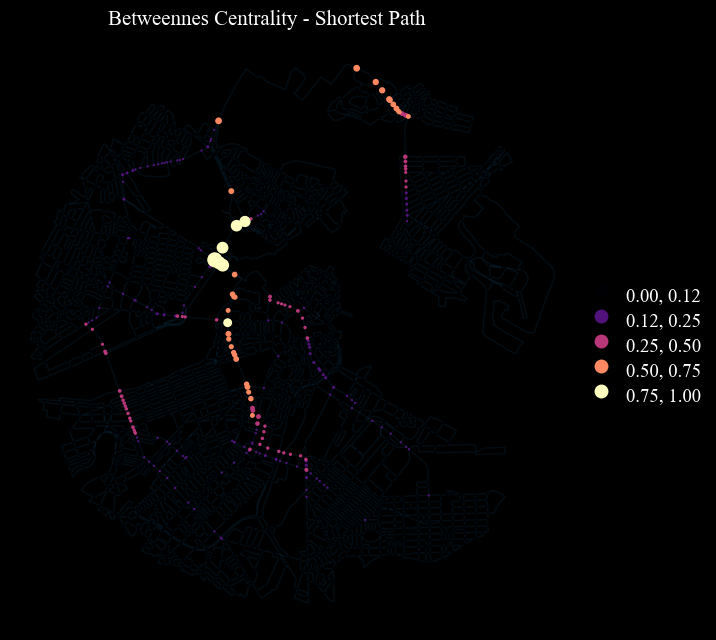

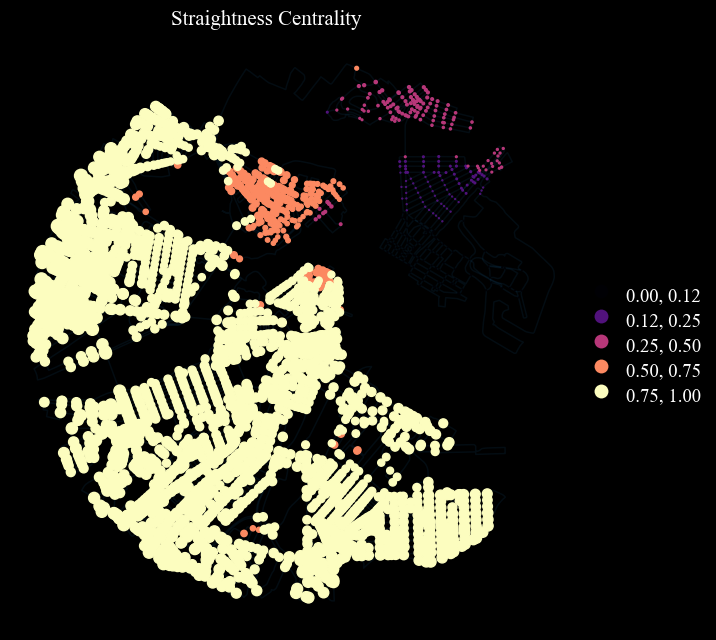

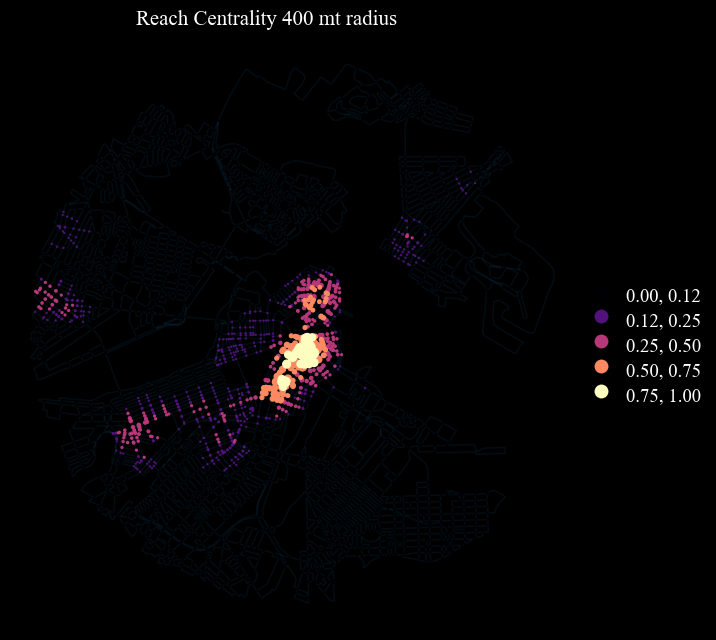

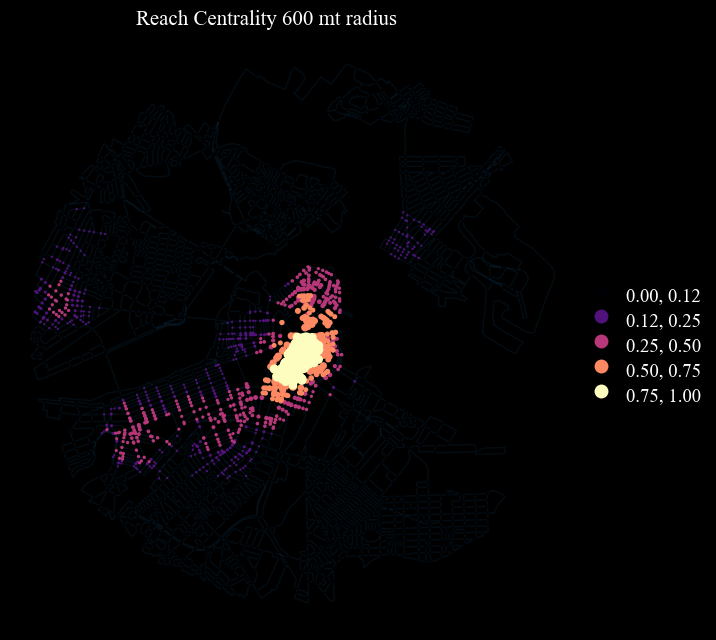

In [20]:
# Lynch's bins - only for variables from 0 to 1 
scheme_dict = {'bins' : [0.125, 0.25, 0.5, 0.75, 1.00], 'scheme' : 'User_Defined'}

#rescaling values for 0-1 visualisation
for n, column in enumerate(columns):
    nodes_graph[column+'_sc'] = ci.scaling_columnDF(nodes_graph[column])
columns_rescaled = [column+'_sc' for column in columns]

for n, column in enumerate(columns_rescaled):
    ci.plot_gdf(nodes_graph, column = column, title = titles[n], cmap = 'magma',
                geometry_size_factor = 5.5, figsize = (7,7), base_map_gdf = edges_graph, base_map_zorder = 0, base_map_alpha = 0.1,
                legend = True, **scheme_dict)

## Paths

On the primal graph representation of the street network, the following centrality measures are computed on edges:
* Road Distance Betweenness centrality.
* Angular Betweenness centrality (On the dual graph representation of the street network)

In [18]:
# Road Distance betweenness centrality
Eb = nx.edge_betweenness_centrality(graph, weight = 'length', normalized = False)

In [19]:
# appending to the geodataframe
if 'Eb' in edges_graph.columns:
    edges_graph.drop(['Eb'], axis = 1, inplace = True)
edges_graph = ci.append_edges_metrics(edges_graph, graph, [Eb], ['Eb'])

### Dual graph analysis: Angular Betweenness

Here street-segments are transformed into nodes (geograpically represented by their centroids). Fictional links represent instead intersections. Thus if two segments are connected in the actual street network, a link in the dual graph representation will be created by connecting the corresponding nodes. This process allows taking advantage of angular relationships in centrality measures computation and other network operations.

In [20]:
# Creating the dual geodataframes and the dual graph.
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)
dual_graph = ci.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\cityImage\graph.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edges_dual = pd.concat([edges_dual, new_row], ignore_index=True)


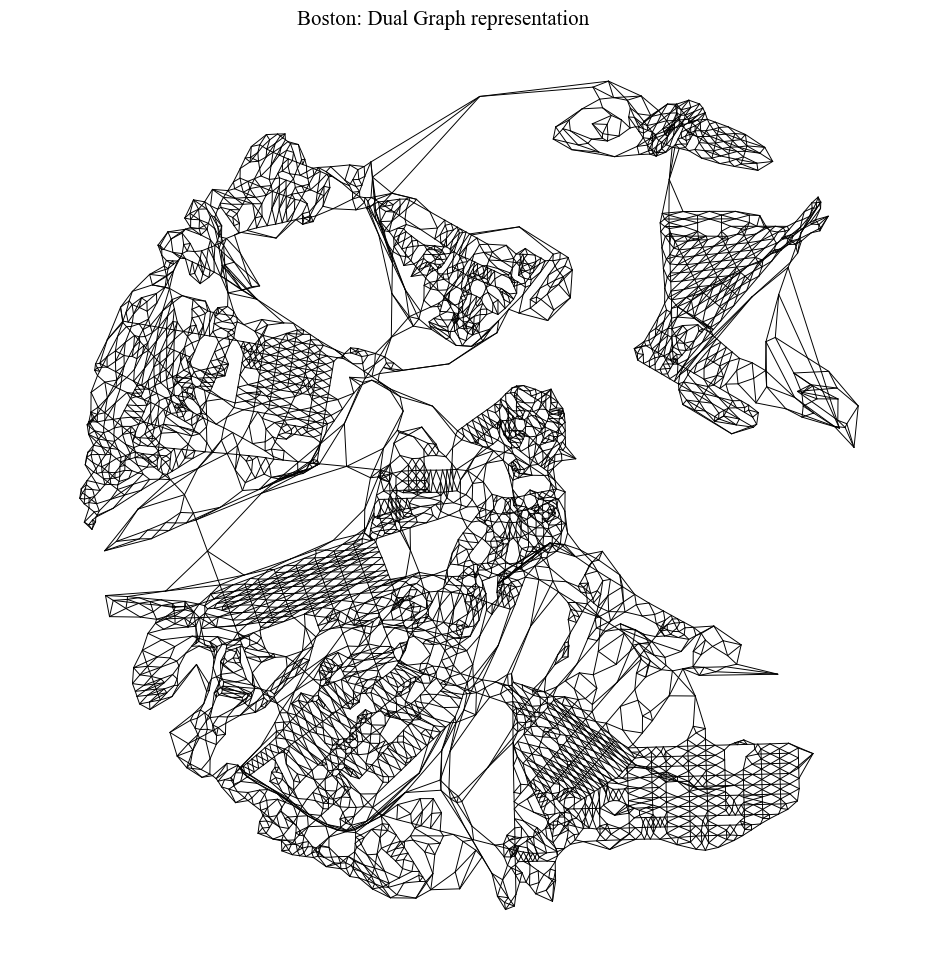

In [21]:
plot = ci.plot_gdf(edgesDual_graph, black_background = False, figsize = (10,10), title = city_name+': Dual Graph representation', 
             color = 'black', geometry_size = 0.7)

In [22]:
# Angular-change betweenness centrality
Ab = nx.betweenness_centrality(dual_graph, weight = 'rad', normalized = False)
edges_graph['Ab'] = edges_graph.edgeID.map(Ab)

**Visualisation**

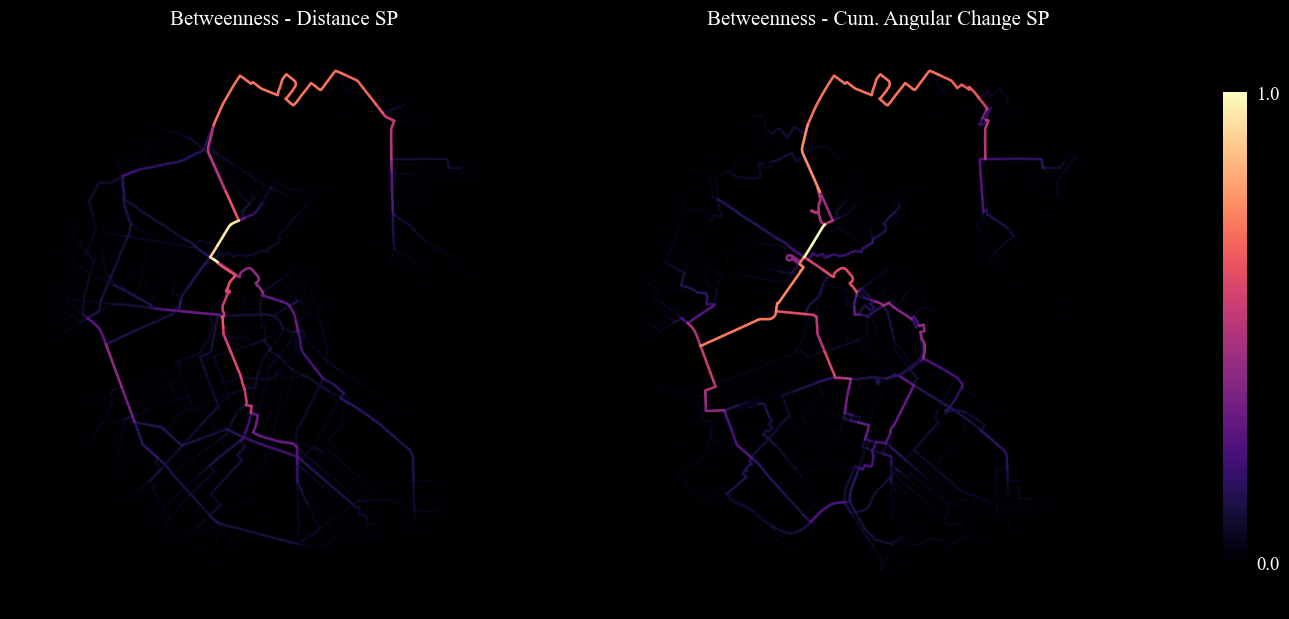

In [23]:
columns = ['Eb', 'Ab']
titles = ['Betweenness - Distance SP', 'Betweenness - Cum. Angular Change SP']
cbar_dict = {'cbar' : True, 'cbar_min_max' : True, 'cbar_shrink' : 0.50}

for n, column in enumerate(columns):
    edges_graph[column+'_sc'] = ci.scaling_columnDF(edges_graph[column])
    
columns_rescaled = [column+'_sc' for column in columns]    
plot = ci.plot_grid_gdf_columns(edges_graph, classes = 8, columns = columns_rescaled, titles = titles, geometry_size = 1.9, 
                                nrows = 1, ncols = 2, scheme = 'Natural_Breaks', cmap = 'magma', figsize = (15 ,10),
                                **cbar_dict)

**Exporting**

In [24]:
# provide path
output_path = '../output/'+city_name

# primal graph
nodes_graph.to_file(output_path+'_nodes.gpkg', driver ='GPKG')
edges_graph.to_file(output_path+'_edges.gpkg', driver ='GPKG')

# dual graph
nodesDual_graph.drop('intersecting', axis=1).to_file(output_path+'_nodesDual.gpkg', driver = 'GPKG')
edgesDual_graph.to_file(output_path+'_edgesDual.gpkg', driver = 'GPKG')